# Word Embeddings and Language Acquisition

In this workshop you will get a chance to experiment with both static  (word2vec/GloVe) and contextual (self-attention) word embeddings.
To do so, you will train your own GPT2 from scratch on "Alice's Adventures in Wonderland".

Along the way you will (hopefully) learn to:
1. Run code in colab
2. Work with python libraries useful for NLP and ML in general (gensim, pytorch, numpy, etc.)
2. Use code from outside [git repo](https://github.com/karpathy/minGPT.git)
3. Build a training dataset from [raw text](https://archive.org/stream/alicesadventures19033gut/19033.txt)
4. Train a Transformer based Language Model from scratch!
5. Generate text using your LM 😀
6. Extract and plot self-attention scores from your model.


To get a feeling for static embedding arithmetic you can play around with the following demo:

https://dash.gallery/dash-word-arithmetic/

(These are word2vec embedding trained on the Google News Dataset.)



To see how easy it is to implement in code you can try out the [gensim](https://radimrehurek.com/gensim/models/keyedvectors.html) library, and check if the same effets reproduce with GloVe embeddings.

The follwoing functions may be helfpul: most_similar and doesnt_match.

In [ ]:
import gensim.downloader as api
word_vectors = api.load("glove-wiki-gigaword-100")


print(word_vectors.similar_by_word("cat", topn = 1))
print(word_vectors.doesnt_match(["breakfast", "cereal", "dinner", "lunch"]))
print(word_vectors.most_similar(positive=['woman', 'king'], negative=['man'], topn = 1))
print(word_vectors.most_similar(positive = ['father', 'woman'], negative = ['man'], topn = 1))



[==================================================] 100.0% 128.1/128.1MB downloaded
[('dog', 0.8798074722290039)]
cereal
[('queen', 0.7698540687561035)]
[('mother', 0.9024619460105896)]




---





It's time to train your very own GPT2!

First, you need to clone the repo and set up the environment.

In [1]:
!git clone https://github.com/karpathy/minGPT.git
!pip install -e 'minGPT/'

Cloning into 'minGPT'...
remote: Enumerating objects: 489, done.
remote: Total 489 (delta 0), reused 0 (delta 0), pack-reused 489
Receiving objects: 100% (489/489), 1.44 MiB | 17.54 MiB/s, done.
Resolving deltas: 100% (261/261), done.
Obtaining file:///content/minGPT
  Preparing metadata (setup.py) ... done
  Running setup.py develop for minGPT


After cloning, go to Runtime and "Restart Session".
Then run the next cell.

In [1]:
import sys
sys.path.insert(0, './minGPT/')

import torch
from torch.utils.data import Dataset
from torch.nn import functional as F
import numpy as np
from mingpt.bpe import get_encoder, BPETokenizer

Here are some consts you'll need for your training.

Feel free to experiment with the different hyper-parameters, but be aware that increasing the BLOCK_SIZE or BATCH_SIZE too much may lead to your colab running out of memory.

Don't forget to upload the text file of "Alice's Adventures in Wonderland" to colab, and update the ALICE_IN_WONDERLAND_PATH const if necessary.

In [2]:
ALICE_IN_WONDERLAND_PATH = 'alice_in_wonderland.txt'
BLOCK_SIZE = 32
VOCAB_SIZE = 50257
NUM_BLOCKS_IN_GPT = 12
MODEL_TYPE = 'gpt2'
NUM_TRAIN_ITERATIONS = 2000
BATCH_SIZE = 32
LEARNING_RATE = 5e-4
NUM_ATTN_HEADS = 12

Now it's time to create a training dataset out of the raw text of "Alice's Adventures in Wonderland".

FIrst, read the text from the file into a string.
Then encode the string using the supplied Byte Pair Encoder.

In the file [bpe.py](https://github.com/karpathy/minGPT/blob/master/mingpt/bpe.py), you can find an example for how to use the encoder.

Instead of encoder.encode_and_show_work() use encoder.encode().
This function will return a list of token indexes corresponding to the text.


In [ ]:
with open(ALICE_IN_WONDERLAND_PATH, 'r') as f:
    AIW_text = f.read()

encoder = get_encoder()
bpe_idx = encoder.encode(AIW_text)

Next, you should write a custom dataset class that gets the token indexes from the encoder as input, inherets from [Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files), and  implements three functions: \_\_init__, \_\_len__, and \_\_getitem__.

The \_\_init__ function just needs to save the token indexes.

The \_\_len__ function returns the number of samples in our dataset (the largest i for which __getitem__ returns a valid sample).

The \_\_getitem__ function loads and returns a sample (input, label) from the dataset at the given index i.
\_getitem_ should return  2 objects of type torch.tensor with dtype=torch.long

Remember that GPT2 is an Auto-Regressive text model so we train the model to predict the next token based on the given prefix.
Meaning that the i-th **input** will be the next block_size tokens up to i, tokens[i : i + block_size] and the **label** will be
tokens[i + 1 : i + block_size + 1].

In [3]:
class AIWDataset(Dataset):
    def __init__(self, bpe_idx):
        self.bpe_idx = bpe_idx

    def __len__(self):
        return len(self.bpe_idx) - BLOCK_SIZE - 1

    def __getitem__(self, i):
        x = torch.tensor(self.bpe_idx[i:i + BLOCK_SIZE], dtype=torch.long)
        y = torch.tensor(self.bpe_idx[i + 1:i + BLOCK_SIZE + 1], dtype=torch.long)
        return x, y


dataset = AIWDataset(bpe_idx)

Now all that's left is to load and train you model.
Check out the README of the minGPT repo for [instructions](https://github.com/karpathy/minGPT/blob/master/README.md).

Use the constants provided above to set the values in model_config (model_type, block_size, vocab_size).

You can add a callback function to your trainer to see how the loss changes during training.
Use the constants provided above to set the values in trainer_config (learning_rate, max_iters, batch_size).

If you haven't changed the hyper-parmeters, training on T4 machine should take ~10m.

If you get out of memory error, try using a smaller version of the model for example 'gpt-mini'

In [4]:
from mingpt.model import GPT
from mingpt.trainer import Trainer


def load_model():
    model_config = GPT.get_default_config()
    model_config.model_type = MODEL_TYPE
    model_config.block_size = BLOCK_SIZE
    model_config.vocab_size = VOCAB_SIZE
    return GPT(model_config)


def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter {trainer.iter_num}: train loss {round(trainer.loss.item(), 3)}")


def train_model(model, train_dataset):
    train_config = Trainer.get_default_config()
    train_config.learning_rate = LEARNING_RATE
    train_config.max_iters = NUM_TRAIN_ITERATIONS
    train_config.batch_size = BATCH_SIZE
    trainer = Trainer(train_config, model, train_dataset)
    trainer.set_callback('on_batch_end', batch_end_callback)
    trainer.init_time = None
    trainer.train_loss_vals = []
    trainer.train_loss_times = []
    trainer.run()
    model.eval()
    return trainer.device


model = load_model()
device = train_model(model, dataset)


number of parameters: 123.68M
running on device cuda
iter 0: train loss 10.925
iter 100: train loss 5.858
iter 200: train loss 4.537
iter 300: train loss 3.857
iter 400: train loss 3.603
iter 500: train loss 3.628
iter 600: train loss 3.403
iter 700: train loss 2.975
iter 800: train loss 3.141
iter 900: train loss 2.869
iter 1000: train loss 2.696
iter 1100: train loss 2.303
iter 1200: train loss 1.921
iter 1300: train loss 1.989
iter 1400: train loss 1.578
iter 1500: train loss 1.472
iter 1600: train loss 1.248
iter 1700: train loss 1.088
iter 1800: train loss 1.021
iter 1900: train loss 0.945


You now have a trained LM - congratulations! 🎉🎉🎉


It's time to put it to the test and generate some text (don't expect any miracles here, all it knows is "Alice's Adventures in Wonderland", so cut it some slack).

You can experiment with different prompts, number of generated tokens, etc.


To do so you will need to use the in-built in function 'generate' of the model (model.generate()), which receives as input:

1. A torch.tensor of dtype=torch.long with the indexes of the tokens in the prompt - just like in training, start with a string prompt of your choosing, encode it using the encoder and convert the result to torch.tensor after wrapping it in list using torch.tensor([encoder_output], dtype=torch.long)

**Note**: very technical but to avoid device error, convert the resulting tensor (t) to the device of the trainer using t.to(device = trainer.device)

2. The number of words to generate - you can choose whatever positive number you like.


The function returns token indexes, which you can covert to tokens/words using `encoder.decode(token_indexes.squeeze().tolist())`

In [5]:
def generate_sentence(model, prompt, length, device, encoder):
    init_idx = torch.tensor([encoder.encode(prompt)], dtype=torch.long).to(device=device)
    idx = model.generate(init_idx, max_new_tokens=length - init_idx.shape[1], do_sample=False, top_k=40)
    return encoder.decode(idx.squeeze().tolist())


generate_sentence(model, 'Alice was walking', 20, device, encoder)

"Alice was walking in with passion.  `I've seen\nhatters before,' she said to"

To understand the contextual embedding your model uses to generate text, we will take a closer look at the self-attention output.

Generate a sentence with at least 10 tokens.
In the last word prediction extract the attention scores
from the **first** and **last** transformer blocks.
Average the scores over the different attention heads.

Using the provided "paint_tokens_by_attention" function, paind the tokens by their attention weight.





To extract the (averaged) attention scores you will need to modify your local **model.py** file at the following points in the code:
1. Return the average attention scores in the *forward* function of the **CausalSelfAttention** class (apply the mean after the softmax before the dropout) as an additional output.
2. Handle this additional output in the *forward* function of the **Block** class, and return it as well.
3. In the *forward* function of the **GPT** class, make sure to save the attention scores from the relevant blocks and return them as a list along side the existing outputs.


You can take the modified file from moodle to run the next section of code.

IMPORTANT NOTE:
After modifying the model.py file you will need to restart your runtime and re-train your model.

To do so change line 93 in **trainer.py** to be:

```
logits, self.loss, _ = model(x, y)

```



With the modified model.py you can generate tokens using the in-build model.forward() function.
Make sure to call `with torch.no_grad():` before the forward function.

This function expects two inputs: torch.tensor of tokens indexes (like before), and attn_block_nums which is a list of blocks from which you would like to extract the attention.

In [40]:
ATTENTION_PROMPT = "The King and Queen of Hearts were seated on their"

prompt_token_idxs = encoder.encode(ATTENTION_PROMPT)
prompt_token_idxs_tensor = torch.tensor([prompt_token_idxs], dtype=torch.long).to(device=device)

with torch.no_grad():
      logits, _, attn_scores = model(prompt_token_idxs_tensor, attn_block_nums=[0, NUM_BLOCKS_IN_GPT - 1])

The function returns three values: logits, loss, attns.

You can ignore the loss, and using the function `logits_to_next_token_idx` get the token index of the word predicted/generated by the model.

Then you can decode this token index using encoder.decode() to get the actual token and print it out.


In [41]:
def logits_to_token_idx(logits):
    next_token_logits = logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1)
    idx = torch.topk(probs, k=1)[1]
    return idx.cpu().tolist()[0]

In [42]:
next_token_index = logits_to_token_idx(logits)
netx_token = encoder.decode(next_token_index)

print(f"Sentence sampled for attention: \n" + ATTENTION_PROMPT + netx_token)

Sentence sampled for attention: 
The King and Queen of Hearts were seated on their throne


attns as returned by the forward function is a tuple of (first_block_att_scores, last_block_att_scores).

This is the attention score for all tokens predicted by the model, so you will need to use `first_block_att_scores.squeeze()[-1]` (and the same for last_block_att_scores) to get the attention for the last predicted token.

So you need to split it, and then pass each of those to the function "paint_tokens_by_attention" function, to paint the tokens by their attention weight.

Remember to pass tokens not the original prompt to this painting function.

To get them you can encode the prompt with the encoder, and then decode each item in the list separately wrapped in a list (the decode() function accepts only lists).

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def paint_tokens_by_attention(tokens, attention_scores):
    plt.cla()
    attn = [attention_scores.cpu().numpy().round(3)]
    plt.table(cellText=attn,
              colLabels=tokens,
              loc='center',
              cellColours=cm.Oranges(attn))
    plt.axis('off')
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.show()

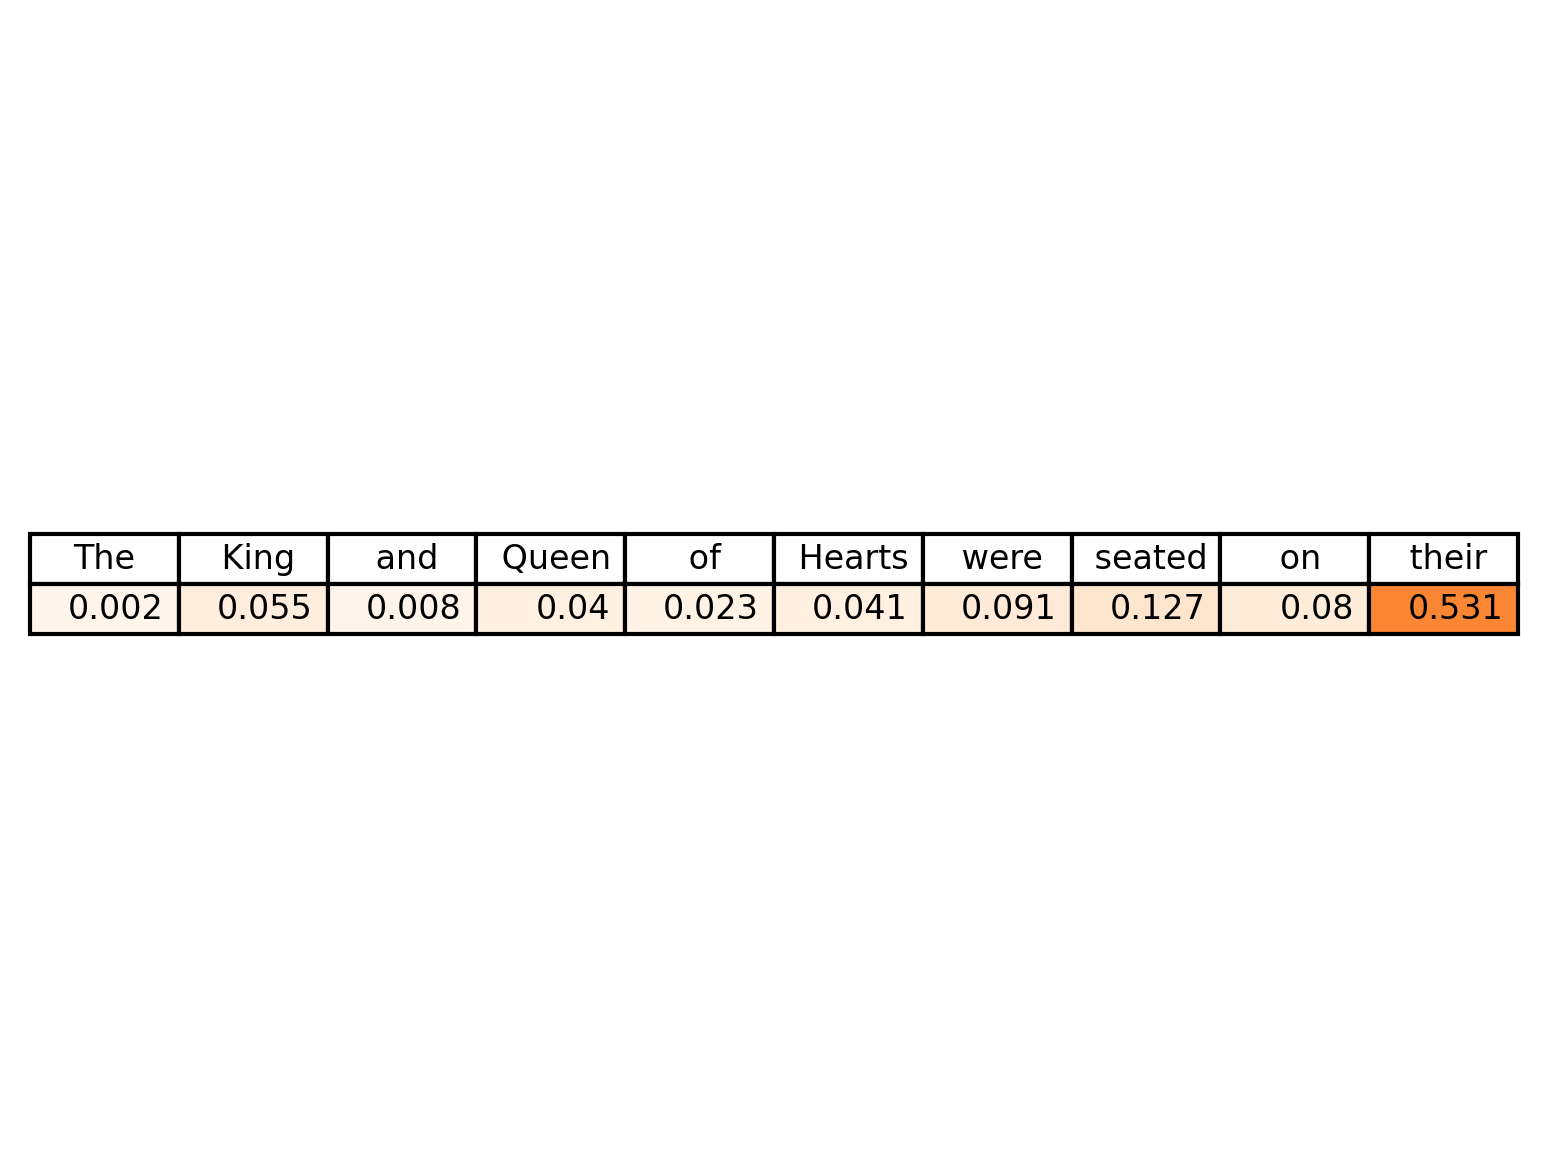

In [43]:
first_block_att_scores, last_block_att_scores = attn_scores
first_block_att_scores = first_block_att_scores.squeeze()[-1]
last_block_att_scores = last_block_att_scores.squeeze()[-1]

prompt_tokens = [encoder.decode([token_idx]) for token_idx in prompt_token_idxs]

paint_tokens_by_attention(prompt_tokens, first_block_att_scores)
paint_tokens_by_attention(prompt_tokens, last_block_att_scores)

Pay attention to the following:
1. What is the sum of all attention scores?
2. What is the difference in attention between the blocks?
3. Based on this analysis why do you think the model "chose" the last word/token?